### Brent Biseda
### W207
### Tuesday @ 4 PM PST

# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
from sklearn.datasets import fetch_openml

X, Y = fetch_openml('mnist_784', return_X_y=True , cache=False)

Y = Y.astype(int)

In [3]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
X, Y = fetch_openml('mnist_784', return_X_y=True , cache=False)
Y = Y.astype(int)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

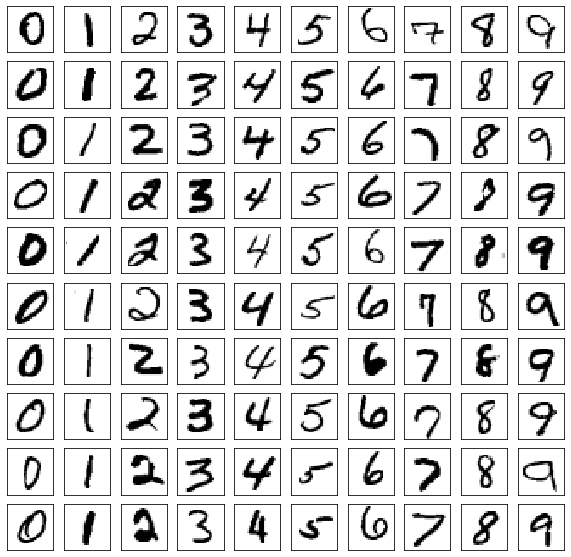

In [4]:
def P1(num_examples=10):
    
    #We will reshape the images into squares
    NUM_PIXELS = 28
    
    # Create 10 columns and rows based on the number of examples
    plt.rcParams["figure.figsize"] = [10, num_examples]
    fig, ax = plt.subplots(nrows=num_examples, ncols=10)
        
    #Iterate over each subplot to create the example images
    for digit in range(10):
        exampleIndex = [int(i) for i in np.where(mini_train_labels==digit)[0].tolist()[:num_examples]]
        for example in range(num_examples):
            #Hide Axes
            ax[example][digit].axes.get_yaxis().set_visible(False)
            ax[example][digit].axes.get_xaxis().set_visible(False)
            
            #Draw the pictures
            ax[example][digit].imshow(mini_train_data[exampleIndex[example]].reshape((NUM_PIXELS,NUM_PIXELS)),cmap="gray_r") 

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [5]:
def P2(k_values):
    accuracy = []
    
    # Iterate through each k in k_values list
    for k in k_values:
        model = KNeighborsClassifier(k)
        model.fit(mini_train_data, mini_train_labels)
        score = model.score(dev_data, dev_labels)
        
        # Show report for k=1
        if k==1:
            predictions = model.predict(dev_data)
            print("Report for k = 1")
            print(classification_report(dev_labels, predictions))
        
        print("k = {}: Accuracy: {:.2f}%".format(k, score*100))
        accuracy.append(score)

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Report for k = 1
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

k = 1: Accuracy: 88.40%
k = 3: Accuracy: 87.60%
k = 5: Accuracy: 88.20%
k = 7: Accuracy: 87.70%
k = 9: Accuracy: 87.50%


ANSWER:

For the k = 1 case, the most difficult digit to classify is the number 8, which has the lowest values for F1 of 0.8.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [6]:
def P3(train_sizes, accuracies):
    #We evaluate accuracy for k=1 only
    k = 1
    times = []
    
    for size in train_sizes:
        
        # Shuffle and select from the training set
        shuffleIndex = np.random.permutation(np.arange(train_data.shape[0]))
        shuffledTrainData = train_data[shuffleIndex][:size]
        shuffledTrainLables = train_labels[shuffleIndex][:size]
        
        #Create Model
        model = KNeighborsClassifier(k)
        model.fit(shuffledTrainData, shuffledTrainLables)

        # Time Model Prediction
        startTime = time.time()
        model.predict(dev_data)
        endTime = time.time()
        
        #Calculate Accuracies & Time
        accuracy = model.score(dev_data, dev_labels)
        accuracies.append(accuracy)
        
        timeDelta = endTime - startTime
        times.append(timeDelta)
        
        print("Set Size: {}, Accuracy: {:.3}, Prediction Time: {:.3} seconds".format(size, accuracy, timeDelta))
        
    return accuracies

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Set Size: 100, Accuracy: 0.726, Prediction Time: 0.138 seconds
Set Size: 200, Accuracy: 0.752, Prediction Time: 0.285 seconds
Set Size: 400, Accuracy: 0.845, Prediction Time: 0.561 seconds
Set Size: 800, Accuracy: 0.865, Prediction Time: 1.1 seconds
Set Size: 1600, Accuracy: 0.907, Prediction Time: 2.5 seconds
Set Size: 3200, Accuracy: 0.921, Prediction Time: 4.87 seconds
Set Size: 6400, Accuracy: 0.938, Prediction Time: 9.91 seconds
Set Size: 12800, Accuracy: 0.952, Prediction Time: 20.0 seconds
Set Size: 25000, Accuracy: 0.956, Prediction Time: 39.8 seconds


[0.726, 0.752, 0.845, 0.865, 0.907, 0.921, 0.938, 0.952, 0.956]

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Set Size: 100, Accuracy: 0.703, Prediction Time: 0.159 seconds
Set Size: 200, Accuracy: 0.754, Prediction Time: 0.274 seconds
Set Size: 400, Accuracy: 0.817, Prediction Time: 0.545 seconds
Set Size: 800, Accuracy: 0.867, Prediction Time: 1.11 seconds
Set Size: 1600, Accuracy: 0.907, Prediction Time: 2.39 seconds
Set Size: 3200, Accuracy: 0.932, Prediction Time: 5.19 seconds
Set Size: 6400, Accuracy: 0.927, Prediction Time: 10.0 seconds
Set Size: 12800, Accuracy: 0.951, Prediction Time: 19.8 seconds
Set Size: 25000, Accuracy: 0.959, Prediction Time: 39.0 seconds
Predicted Accuracy for n=60,000 without transformation:  [1.24665803]
Predicted Accuracy for n=60,000 with transformation:  [0.99780285]


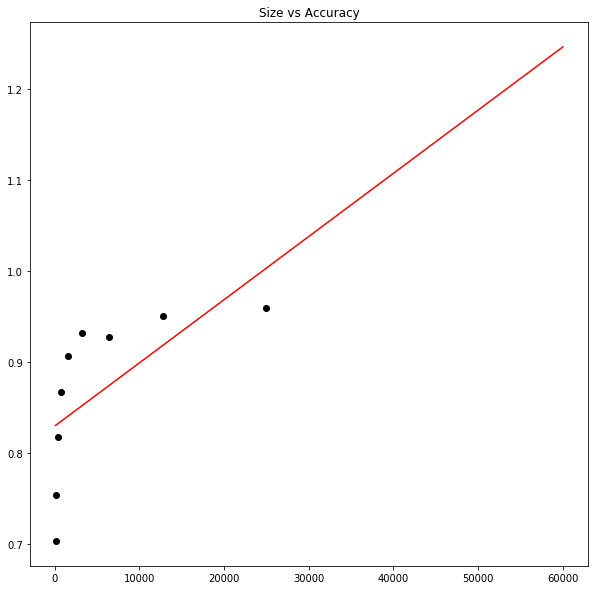

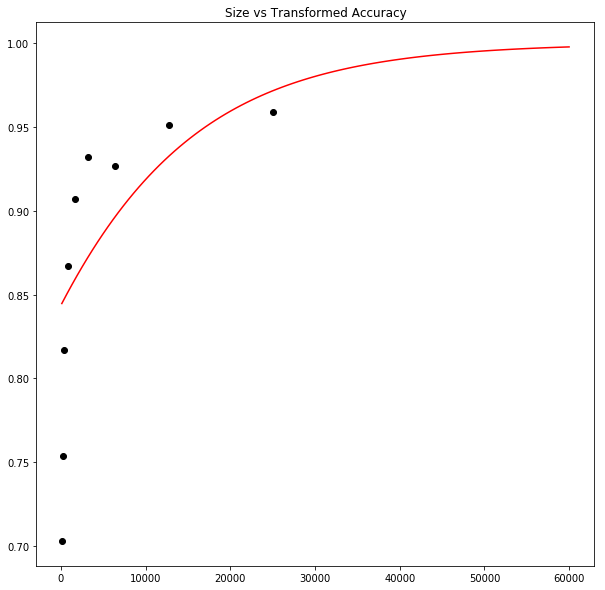

In [7]:
def P4():
    train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
    accuracies = P3(train_sizes, [])
    accuracies = np.array(accuracies)
    
    #Change Format of data for linear regression
    train_sizes = np.array(train_sizes)
    train_sizes = train_sizes.reshape(-1, 1)
        
    #Create Linear Model
    model = LinearRegression()
    model.fit(train_sizes, accuracies)
    preds = model.predict(train_sizes)
    
    #Create continuous linear space to plot the predictions
    xSpace = np.linspace(100,60000,100).reshape(-1, 1)
    ySpace = model.predict(xSpace)
    
    #Training Size vs Accuracy
    plt.figure(1)
    plt.plot(train_sizes, accuracies, "ko", xSpace, ySpace, "r")
    plt.title("Size vs Accuracy")
    
    print("Predicted Accuracy for n=60,000 without transformation: ", model.predict(np.array([60000]).reshape(-1,1)))
    
    #Apply a Logistic Regression Function
    #Based on page 135 of "Hands-On Machine Learning with Scikit-Learn & Tensor Flow"
    logAccuracies = np.log(accuracies / (1-accuracies))
    
    #Create Linear Model
    modelLog = LinearRegression()
    modelLog.fit(train_sizes, logAccuracies)
    predsLog = modelLog.predict(train_sizes)
    
    #Create continuous linear space to plot a smoothed curve from transformation
    xSpace = np.linspace(100,60000,100).reshape(-1, 1)
    ySpace = 1/(1+np.exp(-modelLog.predict(xSpace)))
    
    #Training Size vs Logistic Accuracy
    plt.figure(2)
    plt.plot(train_sizes, accuracies, "ko", xSpace, ySpace, "r")
    plt.title("Size vs Transformed Accuracy")
    logPredAccuracy = 1/(1+np.exp(-modelLog.predict(np.array([60000]).reshape(-1,1))))
    print("Predicted Accuracy for n=60,000 with transformation: ", logPredAccuracy)

P4()

ANSWER:

Using a linear model results in an accuracy prediction in excess of 100% (125%).  Using a logistic transformation, which, constrains the values between 0 and 1 is applicable.  Here we can predict an accuracy of 99.8% when using the transformation.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]
Most confused values are 4's that are identified as 9's


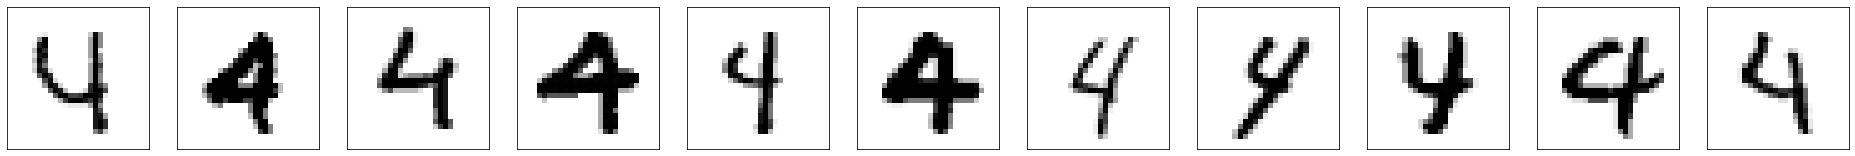

In [8]:
def P5():

    k = 1
    
    #Create Model
    model = KNeighborsClassifier(k)
    model.fit(mini_train_data, mini_train_labels)
    
    #Predict values
    preds = model.predict(dev_data)
    
    #Create Confusion Matrix
    confMatrix = confusion_matrix(dev_labels, preds, labels=np.unique(dev_labels))
    print(confMatrix)
    
    #From inspection of the confusion matrix, we can identify the most frequently confused values are 4's and 9's.
    print("Most confused values are 4's that are identified as 9's")    
    
    #Plot the incorrect values:
    all4 = np.where(dev_labels==4)[0]
    confused4 = np.where(preds[all4]==9)[0]
    incorrectLabel = [all4[i] for i in confused4]
    
    plt.rcParams["figure.figsize"] = [3*confused4.shape[0],3]
    fig, ax = plt.subplots(nrows=1, ncols=confused4.shape[0])  
    
    #We will reshape the images into squares
    NUM_PIXELS = 28
        
    #Iterate over each subplot to create the example images
    for example in range(len(confused4)):
        #Hide Axes
        ax[example].axes.get_yaxis().set_visible(False)
        ax[example].axes.get_xaxis().set_visible(False)

        #Draw the pictures
        ax[example].imshow(dev_data[incorrectLabel[example]].reshape((NUM_PIXELS,NUM_PIXELS)),cmap="gray_r")


P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [9]:
def P6():
    #implement the manual gaussian blur, selecting the 8 possible closest points
    #choose +/- 4 when possible but adjusts if not
    
    def Blur(digit):
        #We assume equal weighting across the 9 potential input values
        DIGIT_DIMENSION = 28

        digit = digit.reshape(DIGIT_DIMENSION, DIGIT_DIMENSION)
        newDigit = np.zeros(digit.shape)

        #Iterate across all potential pixels
        for x in range(digit.shape[0]):
            for y in range(digit.shape[1]):

                #Initialize with original value
                count = 1
                sumValues = digit[x][y]

                #Check position of 8 neighbors
                if x - 1 >= 0:
                    count += 1
                    sumValues += digit[x-1][y]
                if x + 1 < DIGIT_DIMENSION:
                    count += 1
                    sumValues += digit[x+1][y]
                if y - 1 >= 0:
                    count += 1
                    sumValues += digit[x][y-1]
                if y + 1 < DIGIT_DIMENSION:
                    count += 1
                    sumValues += digit[x][y+1]
                if (x - 1 >= 0) and (y - 1 >= 0):
                    count += 1
                    sumValues += digit[x-1][y-1]
                if (x + 1 < DIGIT_DIMENSION) and (y + 1 < DIGIT_DIMENSION):
                    count += 1
                    sumValues += digit[x+1][y+1]
                if (x - 1 >= 0) and (y + 1 < DIGIT_DIMENSION):
                    count += 1
                    sumValues += digit[x-1][y+1]
                if (x + 1 < DIGIT_DIMENSION) and (y - 1 >= 0):
                    count += 1
                    sumValues += digit[x+1][y-1]

                #Take average of neighbor values
                newDigit[x][y] = sumValues / count

        newDigit = newDigit.reshape(DIGIT_DIMENSION*DIGIT_DIMENSION)
        return newDigit
        
    def BlurSet(dataSet):
        #Blur all digits in particular dataset
        newDataSet = dataSet.copy()
        for row in range(dataSet.shape[0]):
            newDataSet[row] = Blur(dataSet[row])
        return  newDataSet
    
    k = 1
    
    mini_train_data_blur = BlurSet(mini_train_data)
    dev_data_blur = BlurSet(dev_data)
    
    #Model 0: Blurring Training Data but not Dev Data
    model0 = KNeighborsClassifier(k)
    model0.fit(mini_train_data, mini_train_labels)
    print("Accuracy for Model 0 with No Blur is {}.".format(model0.score(dev_data, dev_labels)))
    
    #Model 1: Blurring Training Data but not Dev Data
    model1 = KNeighborsClassifier(k)
    model1.fit(mini_train_data_blur, mini_train_labels)
    print("Accuracy for Model 1 with Blurred Training Data is {}.".format(model1.score(dev_data, dev_labels)))
    
    #Model 2: Blurring Dev Data but not Training Data
    model2 = KNeighborsClassifier(k)
    model2.fit(mini_train_data, mini_train_labels)
    print("Accuracy for Model 2 with Blurred Test Data is {}.".format(model2.score(dev_data_blur, dev_labels)))
    
    #Model 3: Blurring Dev Data and also Training Data
    model3 = KNeighborsClassifier(k)
    model3.fit(mini_train_data_blur, mini_train_labels)
    print("Accuracy for Model 3 with Blurred Training and Test Data is {}.".format(model3.score(dev_data_blur, dev_labels)))
    
P6()

Accuracy for Model 0 with No Blur is 0.884.
Accuracy for Model 1 with Blurred Training Data is 0.908.
Accuracy for Model 2 with Blurred Test Data is 0.868.
Accuracy for Model 3 with Blurred Training and Test Data is 0.904.


ANSWER:

We can see that we have the best performance with blur applied to the training data but not to the development data.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [20]:
def ComputeThresholds(data, thresholds):
    
    #Create new data of all zeroes
    newData = np.zeros(data.shape)
    
    #iterate through thresholds
    for i, threshold in enumerate(thresholds):
        #Set the new data 
        newData[mini_train_data>threshold] = i + 1
    
    return newData

def P7():
    #Binarize with the training data using a threshold
    ALPHA = 1
    THRESHOLD = 0.1
    model = BernoulliNB(alpha=ALPHA, binarize=THRESHOLD)
    model.fit(mini_train_data, mini_train_labels)
    print("Accuracy of Bernoulli Model: {}".format(model.score(dev_data, dev_labels)))
    
    #Binarize to White, Gray, or Black
    #Thresholds selected arbitrarily
    THRESHOLDS = [0.1, 0.5]
    
    mini_train_data_multi = ComputeThresholds(mini_train_data, THRESHOLDS)
    dev_data_multi = ComputeThresholds(dev_data, THRESHOLDS)
    
    # Fit model
    model2 = MultinomialNB(alpha=ALPHA)
    model2.fit(mini_train_data_multi, mini_train_labels)    
    print("Accuracy of Mulinomial Model: {}".format(model2.score(dev_data_multi, dev_labels)))

P7()

Accuracy of Bernoulli Model: 0.814
Accuracy of Mulinomial Model: 0.12


ANSWER:

The multi-class model has much worse performance.  This is likely because the particular thresholds are arbitrary and could be refined.  It is likely that there are very few values that are set to 2 because the threshold is too high.  It is probably more effective to tweak the threshold values to improve the performance.  I was able to check this using the single binarize model to confirm this fact.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [21]:
def P8(alphas):
    
    #Select an arbitrary threshold to binarize
    THRESHOLD = 0.1
    
    #Create Grid
    model1 = BernoulliNB(binarize=THRESHOLD)
    grid = GridSearchCV(model1, alphas)
    grid.fit(mini_train_data, mini_train_labels)
    
    for i in alphas['alpha']:
        model = BernoulliNB(alpha=i, binarize=THRESHOLD)
        model.fit(mini_train_data, mini_train_labels)
        print("Accuracy of Bernoulli Model with alpha {} : {}".format(i, model.score(dev_data, dev_labels)))
    
    return grid

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\bisedab\AppData\Local\Contin

Accuracy of Bernoulli Model with alpha 0.0 : 0.813
Accuracy of Bernoulli Model with alpha 0.0001 : 0.826
Accuracy of Bernoulli Model with alpha 0.001 : 0.829
Accuracy of Bernoulli Model with alpha 0.01 : 0.83
Accuracy of Bernoulli Model with alpha 0.1 : 0.825
Accuracy of Bernoulli Model with alpha 0.5 : 0.818
Accuracy of Bernoulli Model with alpha 1.0 : 0.814
Accuracy of Bernoulli Model with alpha 2.0 : 0.811
Accuracy of Bernoulli Model with alpha 10.0 : 0.778


In [22]:
print(nb.best_params_)

{'alpha': 0.0001}


ANSWER:

Alpha of 0.0001 is best from the training data.  I am surprised that the value is nearly the same with an alpha of 0.  I would have assumed that it would have an accuracy of ~10%, or chance when selecting the value.  

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [32]:
def P9():
    
    #Create a GuassianNB Model
    model = GaussianNB()
    model.fit(mini_train_data, mini_train_labels)
    print("Accuracy for dev data: {:.3}%".format(model.score(dev_data, dev_labels)*100))
       
    #The data is highly skewed toward 0.  We can use SKlearn's scale functions to correct for this
    from sklearn.preprocessing import scale
    
    mini_train_data_scaled = np.zeros(mini_train_data.shape)
    dev_data_scaled = np.zeros(dev_data.shape)
    
    for row in range(len(mini_train_data)):
        mini_train_data_scaled[row] = scale(mini_train_data[row])
    
    for row in range(len(dev_data)):
        dev_data_scaled[row] = scale(dev_data[row])
    
    
    #Create scaled model
    model2 = GaussianNB()
    model2.fit(mini_train_data_scaled, mini_train_labels)
    print("Accuracy for Scaled dev data: {:.3}%".format(model2.score(dev_data_scaled, dev_labels)*100))
    
    #Try another Model that Adds Noise to the Data
    mini_train_data_noise = mini_train_data + np.random.uniform(size = mini_train_data.shape)
    dev_data_noise = dev_data + np.random.uniform(size = dev_data.shape)
    
    #Create Noisy model
    model3 = GaussianNB()
    model3.fit(mini_train_data_noise, mini_train_labels)
    print("Accuracy for Noisy dev data: {:.3}%".format(model3.score(dev_data_noise, dev_labels)*100))
    
    #Try another Model that Adds Noise to the Already Scaled Data
    mini_train_data_scaled_noise = mini_train_data_scaled + np.random.uniform(size = mini_train_data.shape)
    dev_data_scaled_noise = dev_data_scaled + np.random.uniform(size = dev_data.shape)
    
    #Create Noisy model
    model4 = GaussianNB()
    model4.fit(mini_train_data_scaled_noise, mini_train_labels)
    print("Accuracy for Scaled & Noisy dev data: {:.3}%".format(model3.score(dev_data_scaled_noise, dev_labels)*100))
    

gnb = P9()

Accuracy for dev data: 59.3%
Accuracy for Scaled dev data: 70.4%
Accuracy for Noisy dev data: 82.4%
Accuracy for Scaled & Noisy dev data: 71.4%


ANSWER:

We only achieve approximately 60% accuracy using the GuassianNB method.  We can improve our accuracy by scaling the data or by adding noise.  We see the best performance by adding noise to the data alone.  This is because the majority of the data is of 0 value, or white space in the image.  This is similar in some ways to the previous excercise of blurring the values.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

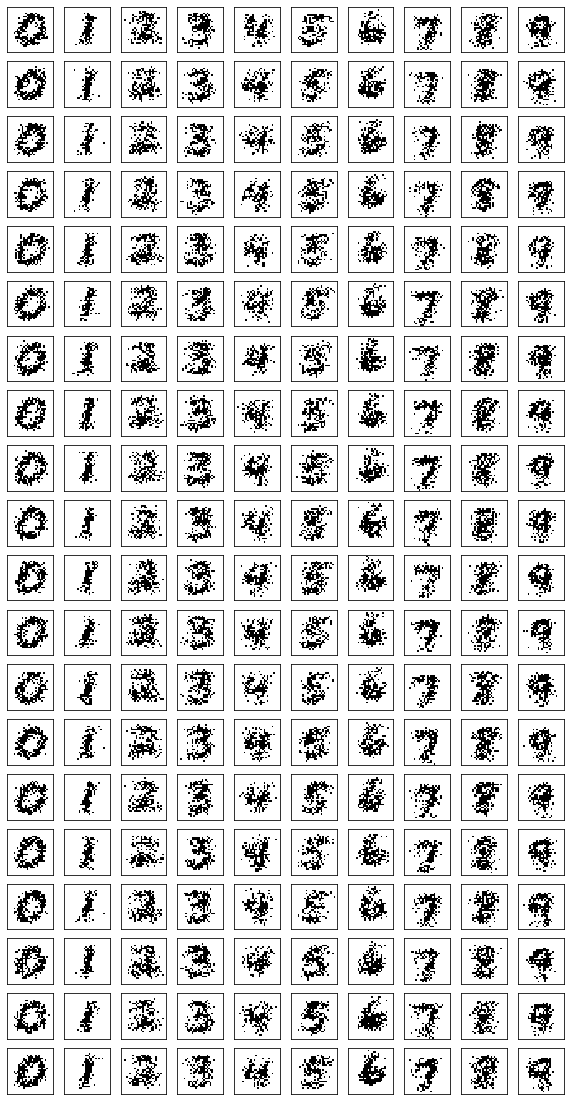

In [47]:
def P10(num_examples):

    #Arbitrarily Define our Parameters
    ALPHA = 0.0001 #Selected from grid search
    THRESHOLD = 0.1
    model = BernoulliNB(alpha=ALPHA, binarize=THRESHOLD)
    model.fit(mini_train_data, mini_train_labels)
    
    logProbs = model.feature_log_prob_
    probs = np.exp(logProbs)
    
    #We will reshape the images into squares
    NUM_PIXELS = 28
    
    # Create 10 columns and rows based on the number of examples
    plt.rcParams["figure.figsize"] = [10, num_examples]
    fig, ax = plt.subplots(nrows=num_examples, ncols=10)
        
    #Iterate over each subplot to create the example images
    for digit in range(10):
        for example in range(num_examples): 
            #Hide Axes
            ax[example][digit].axes.get_yaxis().set_visible(False)
            ax[example][digit].axes.get_xaxis().set_visible(False)
            
            #Generate the Digits
            bernoulliDigit = probs[digit] > np.random.rand(probs.shape[1])
            #bernoulliDigit = probs[digit] > 0.1
            
            #Draw the pictures
            ax[example][digit].imshow(bernoulliDigit.reshape(NUM_PIXELS, NUM_PIXELS), cmap="gray_r") 

P10(20)

ANSWER:

These models are basically averages of the training data.  We created the digits from a random distribution so we can see the noise.  It is also possible to eliminate the noise by setting a particular cutoff and visualizing the data with a different methodology.  

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [70]:
def P11(buckets, correct, total):
    
    #Choose our Parameters
    ALPHA = 0.0001
    THRESHOLD = 0.1
    
    #Train our model
    model = BernoulliNB(alpha=ALPHA, binarize=THRESHOLD)
    model.fit(mini_train_data, mini_train_labels)
    
    #Generate Predictions
    preds = model.predict(dev_data)
    predsProbs = model.predict_proba(dev_data)
    
    #Iterate through data and set correct & totals
    for i, prediction in enumerate(preds):
        
        maxProb = max(predsProbs[i])
        bucketUpdate = (maxProb >= buckets)
        
        #Setup for all 0's
        correctUpdate = [0 for i in range(len(bucketUpdate))]
        
        #If label is correct then we update correct values for each of the appropriate buckets
        if(prediction == dev_labels[i]):
            correctUpdate = bucketUpdate
        
        correct += correctUpdate
        total += bucketUpdate
    
    return (correct, total)      
    
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

correct, total = P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total = 1000    accuracy = 0.826
p(pred) <= 0.9000000000000    total = 960    accuracy = 0.840
p(pred) <= 0.9990000000000    total = 908    accuracy = 0.869
p(pred) <= 0.9999900000000    total = 846    accuracy = 0.891
p(pred) <= 0.9999999000000    total = 788    accuracy = 0.915
p(pred) <= 0.9999999990000    total = 740    accuracy = 0.924
p(pred) <= 0.9999999999900    total = 698    accuracy = 0.934
p(pred) <= 0.9999999999999    total = 651    accuracy = 0.945
p(pred) <= 1.0000000000000    total = 627    accuracy = 0.951


ANSWER:

We can see that as the posterior probability increases, the accuracy increases.  This implies that this Naive bayes model is well-calibrated. As the predicted probability approaches 1, our accuracy also improves.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [103]:
def CalcSums(data):
    """Calculate Non-Normalized Sums (These will have values greater than 1 potentially)"""
    
    #We will reshape the images into squares
    NUM_PIXELS = 28
    
    sums = np.zeros((data.shape[0], NUM_PIXELS*2))
                    
    for i, digit in enumerate(data):
        digit = digit.reshape(NUM_PIXELS, NUM_PIXELS)
        
        #Let's normalize so we don't have values in excess of 1
        rowSums = np.sum(digit, axis = 1)
        colSums = np.sum(digit, axis = 0)
        sums[i] = np.append(rowSums, colSums)
    
    #Combine the data with the normalized sums by stacking together
    sums = np.hstack((data, sums))
    
    return sums

def CalcNormSums(data):
    """Calculate Normalized Sums"""
    
    #We will reshape the images into squares
    NUM_PIXELS = 28
    
    sums = np.zeros((data.shape[0], NUM_PIXELS*2))
                    
    for i, digit in enumerate(data):
        digit = digit.reshape(NUM_PIXELS, NUM_PIXELS)
        
        #Let's normalize so we don't have values in excess of 1
        rowSums = np.sum(digit, axis = 1)
        rowSums = rowSums / np.amax(rowSums)
        
        colSums = np.sum(digit, axis = 0)
        colSums = colSums / np.amax(colSums)
        sums[i] = np.append(rowSums, colSums)
    
    #Combine the data with the normalized sums by stacking together
    sums = np.hstack((data, sums))
    
    return sums
                    
def P12():
    #Implemented Sums for Rows and Columns that are Normalized
    
    #Choose our Parameters
    ALPHA = 0.0001
    THRESHOLD = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0]
    
    for i in THRESHOLD:
        
        print("THRESHOLD VALUE OF ", i)
        print("=====================================================")
    
        #Train our model
        model = BernoulliNB(alpha=ALPHA, binarize=i)
        model.fit(mini_train_data, mini_train_labels)

        print("Accuracy for Regular Model dev data: {:.3}%".format(model.score(dev_data, dev_labels)*100))

        mini_train_data_sums = CalcNormSums(mini_train_data)
        dev_data_sums = CalcNormSums(dev_data)

        #Train our model
        model2 = BernoulliNB(alpha=ALPHA, binarize=i)
        model2.fit(mini_train_data_sums, mini_train_labels)

        print("Accuracy for with Normalized Sums: {:.3}%".format(model2.score(dev_data_sums, dev_labels)*100))

        mini_train_data_sums = CalcSums(mini_train_data)
        dev_data_sums = CalcSums(dev_data)

        #Train our model
        model3 = BernoulliNB(alpha=ALPHA, binarize=i)
        model3.fit(mini_train_data_sums, mini_train_labels)

        print("Accuracy for with Non-Normalized Sums: {:.3}%".format(model3.score(dev_data_sums, dev_labels)*100))
        print("\n")

P12()

THRESHOLD VALUE OF  0.1
Accuracy for Regular Model dev data: 82.6%
Accuracy for with Normalized Sums: 82.0%
Accuracy for with Non-Normalized Sums: 82.1%


THRESHOLD VALUE OF  0.2
Accuracy for Regular Model dev data: 83.0%
Accuracy for with Normalized Sums: 83.2%
Accuracy for with Non-Normalized Sums: 82.5%


THRESHOLD VALUE OF  0.3
Accuracy for Regular Model dev data: 83.6%
Accuracy for with Normalized Sums: 84.5%
Accuracy for with Non-Normalized Sums: 82.8%


THRESHOLD VALUE OF  0.4
Accuracy for Regular Model dev data: 82.8%
Accuracy for with Normalized Sums: 84.1%
Accuracy for with Non-Normalized Sums: 81.8%


THRESHOLD VALUE OF  0.5
Accuracy for Regular Model dev data: 82.2%
Accuracy for with Normalized Sums: 84.7%
Accuracy for with Non-Normalized Sums: 82.4%


THRESHOLD VALUE OF  0.6
Accuracy for Regular Model dev data: 82.6%
Accuracy for with Normalized Sums: 84.2%
Accuracy for with Non-Normalized Sums: 82.6%


THRESHOLD VALUE OF  0.7
Accuracy for Regular Model dev data: 82.2%
Acc

Changing the Threshold value resulted in different accuracy for the new features.  With a threshold of 0.1, the model performs worse with these new features.  We can see that the best performance occurs for normalized row and column sums with a threshold value of 0.5.